# Stock Market Trend Prediction using Random Forest classification model to predict stock trends.

In [12]:
# importing dependencies
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# reading data of S&P500
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = 'max')
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


<Axes: xlabel='Date'>

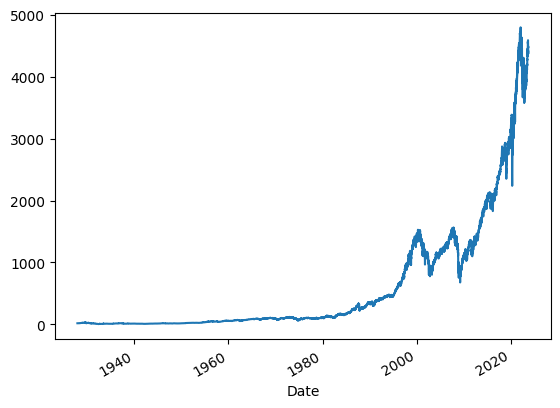

In [14]:
sp500['Close'].plot(kind = 'line')

In [15]:
# removing unnecessary columns
sp500 = sp500.drop(columns = ['Dividends', 'Stock Splits'])
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0


In [16]:
# constructing a classition systems for determining whether the stock price increases or not
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0


In [17]:
# slicing the data from 1990-01-01 onwards
sp500 = sp500.loc['1990-01-01':].copy()
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [18]:
# defining models and fitting the models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [19]:
# measuring the precision of our model using precision_score from sklearn
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5535714285714286

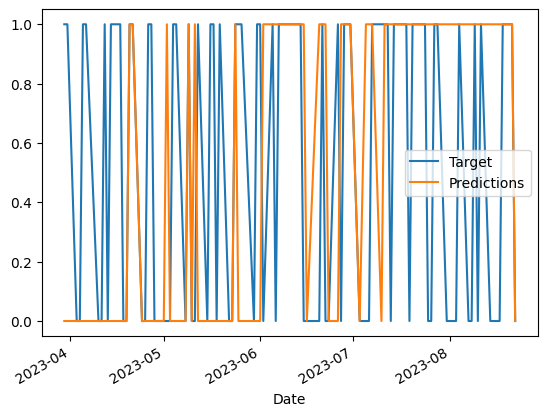

In [20]:
# a visualisation of how our model perform
test['Target'].plot(kind = 'line')
preds.plot(kind = 'line')
plt.legend(['Target', 'Predictions'], loc = 'right')

In [21]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [22]:
predictions = backtest(sp500, model, predictors)
predictions.head()

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0


In [23]:
precision_score(predictions["Target"], predictions['Predictions'])

0.529110936270653

# Improvements on Random Forest predictions using rolling mean

In [24]:
horizons = [2, 5, 60, 250, 1000] # 60 is about 3 months, 250 is last year, 1000 is last 4 years
new_predictors = []

for x in horizons:
    rolling_avg = sp500.rolling(x).mean()

    ratio_column = f'Close ratio {x}'
    sp500[ratio_column] = sp500['Close'] / rolling_avg['Close']

    trend_column = f'Trend over {x}'
    sp500[trend_column] = sp500.shift(1).rolling(x).sum()['Target']

    new_predictors += [ratio_column, trend_column]

In [25]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close ratio 2,Trend over 2,Close ratio 5,Trend over 5,Close ratio 60,Trend over 60,Close ratio 250,Trend over 250,Close ratio 1000,Trend over 1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,4370.359863,0,0.996208,0.0,0.989080,2.0,0.999356,33.0,1.082203,119.0,1.146648,533.0
2023-08-17 00:00:00-04:00,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,4369.709961,0,0.996129,0.0,0.985811,1.0,0.990981,32.0,1.073764,118.0,1.137360,533.0
2023-08-18 00:00:00-04:00,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,4399.770020,1,0.999926,0.0,0.989877,1.0,0.989996,32.0,1.073455,118.0,1.136752,532.0


In [26]:
sp500 = sp500.dropna()

In [27]:
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = 1)


In [28]:
# we change our predict function to use probability

def predict_prob(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] # getting the second column which is just the probability of price go up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest_prob(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_prob(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [29]:
predictions = backtest_prob(sp500, model, new_predictors)


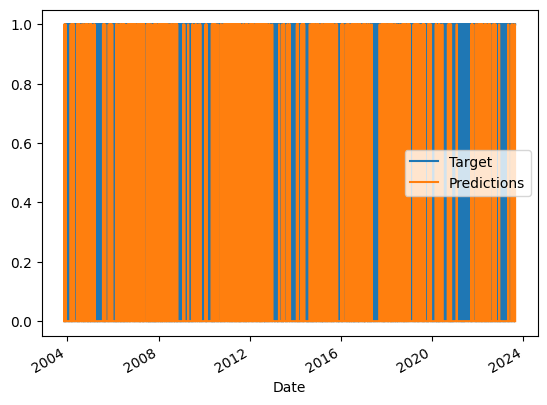

In [30]:
predictions['Target'].plot(kind = 'line')
predictions['Predictions'].plot(kind = 'line')
plt.legend(['Target', 'Predictions'], loc = 'right')

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5695121951219512

### Improvements on Random Forest predictions using directional tracker instead of rolling to predict trend and prices.

In [32]:
# Redefining sp500
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = 'max')
sp500 = sp500.drop(columns = ['Dividends', 'Stock Splits'])
sp500.head()

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0


In [33]:
# Creating target for trends
sp500['Target'] = (sp500['Close'].shift(-1) > sp500['Close']).astype(int)

# creating mean rolling for 2, 5, 60, 250, 1000
horizons = [2, 5, 60, 250, 1000]

for x in horizons:
    sp500[f'MR{x}'] = sp500['Close'].rolling(x).mean()
    sp500[f'MRD{x}'] = sp500['Close'] - sp500[f'MR{x}']

sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000
Date,,,,,,,,,,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0,17.710000,0.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0,17.740000,-0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,1,17.634999,-0.085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0,17.605000,0.055,17.67,-0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# dropping NA entries
sp500 = sp500.dropna()

In [35]:
# defining model
model = RandomForestClassifier(n_estimators=200, min_samples_split = 50, random_state = 1)

In [36]:
# slight modification to the previous prob predict and backtest functions
def predict_prob(train, test, predictors, target, model):
    model.fit(train[predictors], train[target])
    preds = model.predict_proba(test[predictors])[:,1] # getting the second column which is just the probability of price go up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)
    return combined

def backtest_prob(data, model, predictors, target, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_prob(train, test, predictors, target, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [37]:
predictors = [f'MRD{x}' for x in horizons]
target_predictions = backtest_prob(sp500, model, predictors, 'Target')

In [38]:
precision_score(predictions["Target"], predictions['Predictions'])

0.5695121951219512

# Price predictions using Support Vector Regression (SVR)

In [39]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
1931-12-28 00:00:00-05:00,7.760000,7.760000,7.760000,7.760000,0,1,7.860000,-0.100000,8.022000,-0.262000,9.721333,-1.961333,13.704760,-5.944760,20.197110,-12.437110,7.960000
1931-12-29 00:00:00-05:00,7.960000,7.960000,7.960000,7.960000,0,1,7.860000,0.100000,7.984000,-0.024000,9.692167,-1.732167,13.675240,-5.715240,20.187410,-12.227410,8.100000
1931-12-30 00:00:00-05:00,8.100000,8.100000,8.100000,8.100000,0,1,8.030000,0.070000,7.946000,0.154000,9.668333,-1.568333,13.644240,-5.544240,20.177750,-12.077750,8.120000
1931-12-31 00:00:00-05:00,8.120000,8.120000,8.120000,8.120000,0,0,8.110000,0.010000,7.980000,0.140000,9.642000,-1.522000,13.613000,-5.493000,20.168150,-12.048150,7.560000
1932-01-04 00:00:00-05:00,7.560000,7.560000,7.560000,7.560000,0,0,7.840000,-0.280000,7.900000,-0.340000,9.621000,-2.061000,13.578720,-6.018720,20.158160,-12.598160,7.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,0,4463.790039,-25.930176,4465.633984,-27.774121,4403.631323,34.228540,4069.262486,368.597377,3839.521970,598.337893,4404.330078
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,0,4421.094971,-16.764893,4452.958008,-48.627930,4407.170492,-2.840413,4069.783646,334.546432,3841.047921,563.282157,4370.359863
2023-08-17 00:00:00-04:00,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,0,4387.344971,-16.985107,4433.263965,-62.904102,4410.132658,-39.772795,4070.130125,300.229738,3842.549121,527.810743,4369.709961


It is clear that from the stock price history of S&P500, the share price is significantly higher than in the 1940s to 2000s. Hence it order to make the model more accurate, we are just gonna use last year for training and testing.

In [40]:
sp500 = sp500[-252:]
sp500

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020
2022-08-24 00:00:00-04:00,4126.549805,4156.560059,4119.970215,4140.770020,3583630000,1,4134.750000,6.020020,4183.942090,-43.172070,3994.383683,146.386336,4345.662439,-204.892420,3532.404088,608.365931,4199.120117
2022-08-25 00:00:00-04:00,4153.259766,4200.540039,4147.589844,4199.120117,3566870000,0,4169.945068,29.175049,4167.018066,32.102051,3995.499854,203.620264,4344.421439,-145.301322,3533.714608,665.405509,4057.659912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15 00:00:00-04:00,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,0,4463.790039,-25.930176,4465.633984,-27.774121,4403.631323,34.228540,4069.262486,368.597377,3839.521970,598.337893,4404.330078
2023-08-16 00:00:00-04:00,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,0,4421.094971,-16.764893,4452.958008,-48.627930,4407.170492,-2.840413,4069.783646,334.546432,3841.047921,563.282157,4370.359863
2023-08-17 00:00:00-04:00,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,0,4387.344971,-16.985107,4433.263965,-62.904102,4410.132658,-39.772795,4070.130125,300.229738,3842.549121,527.810743,4369.709961


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from statsmodels.tools.eval_measures import mse

predictors += [f'MR{x}' for x in horizons]

X = sp500[predictors]
y = sp500[['Tomorrow']]
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [42]:
from sklearn.svm import SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

regressor = SVR(kernel = 'poly')
regressor.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='poly')

In [43]:
y_pred = regressor.predict(X_test_scaled)
y_pred.shape

(100,)

In [44]:
sp500_test = sp500[-100:]
sp500_test['Preds'] = y_pred


<ipython-input-44-77c10fe92fa0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['Preds'] = y_pred


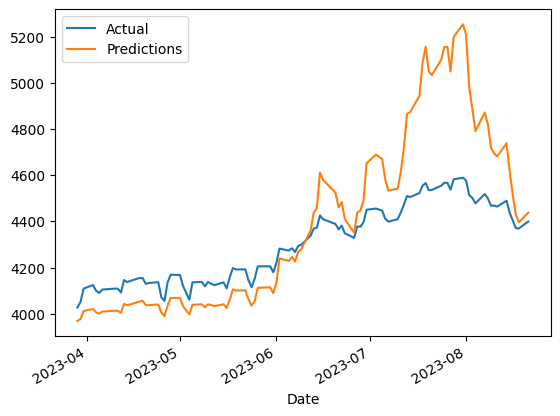

In [45]:
sp500_test['Close'].plot(kind = 'line')
sp500_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

The predictions trend seems to accurately predicting the actual data.

In [46]:
sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020
2022-08-24 00:00:00-04:00,4126.549805,4156.560059,4119.970215,4140.770020,3583630000,1,4134.750000,6.020020,4183.942090,-43.172070,3994.383683,146.386336,4345.662439,-204.892420,3532.404088,608.365931,4199.120117
2022-08-25 00:00:00-04:00,4153.259766,4200.540039,4147.589844,4199.120117,3566870000,0,4169.945068,29.175049,4167.018066,32.102051,3995.499854,203.620264,4344.421439,-145.301322,3533.714608,665.405509,4057.659912


In [47]:
# scaling sp500 dataframe by standardisation

m = sp500.mean()
std = sp500.std(ddof = 1)
sp500_scaled = (sp500 - m) / std
sp500_scaled

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-19 00:00:00-04:00,0.810882,0.718164,0.703283,0.647393,-0.550634,-0.951569,0.767479,-1.208130,0.870716,-1.032315,-0.204352,1.251812,2.126393,-0.309771,-1.620447,1.775563,0.267753
2022-08-22 00:00:00-04:00,0.513837,0.413344,0.343228,0.271510,-0.367356,-0.951569,0.463037,-1.971971,0.736098,-2.242823,-0.186620,0.626424,2.114797,-0.586888,-1.606946,1.240357,0.229402
2022-08-23 00:00:00-04:00,0.255325,0.262240,0.319599,0.233044,-0.472626,1.046726,0.254680,-0.210763,0.586829,-1.705588,-0.178727,0.556316,2.102562,-0.611118,-1.593550,1.179165,0.279265
2022-08-24 00:00:00-04:00,0.228052,0.248503,0.303147,0.283057,-0.773580,1.046726,0.260486,0.251068,0.474102,-0.907094,-0.180672,0.639110,2.091600,-0.569574,-1.579971,1.242158,0.520916
2022-08-25 00:00:00-04:00,0.339438,0.436710,0.415085,0.525436,-0.794606,-0.951569,0.407517,1.255157,0.402525,0.646269,-0.173215,1.023390,2.081270,-0.384229,-1.565665,1.574972,-0.064927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-15 00:00:00-04:00,1.697302,1.627787,1.568522,1.517130,-0.461673,-0.951569,1.635081,-1.134413,1.665458,-0.589341,2.553303,-0.113941,-0.209193,1.214142,1.772388,1.183646,1.370773
2023-08-16 00:00:00-04:00,1.509308,1.504028,1.452449,1.377851,-0.559955,-0.951569,1.456719,-0.736972,1.611848,-1.019682,2.576946,-0.362829,-0.204855,1.108234,1.789045,0.979103,1.230088
2023-08-17 00:00:00-04:00,1.436454,1.380866,1.295524,1.236744,-0.321854,-0.951569,1.315725,-0.746521,1.528556,-1.314286,2.596735,-0.610801,-0.201971,1.001499,1.805431,0.772135,1.227397


In [48]:
predictors = ['MR2', 'MR5', 'MRD2', 'MRD5']

X = sp500_scaled[predictors]
y = sp500_scaled[['Tomorrow']]
X_train_scaled = X[:-100]
X_test_scaled = X[-100:]
y_train_scaled = y[:-100]
y_test_scaled = y[-100:]

In [49]:
# defining and fitting model to test data
regressor = SVR(kernel = 'poly')
regressor.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='poly')

In [50]:
y_pred_scaled = regressor.predict(X_test_scaled)

<ipython-input-51-444d5a5474e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_scaled_test['Preds'] = y_pred_scaled


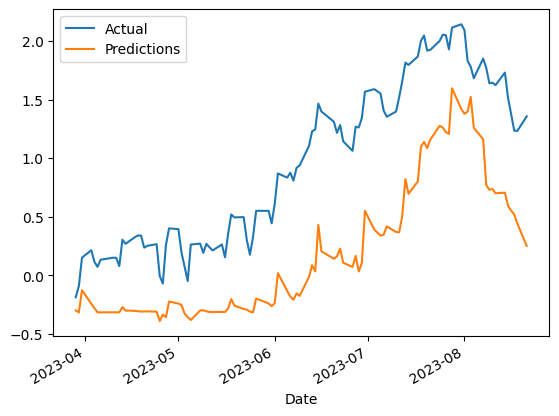

In [51]:
sp500_scaled_test= sp500_scaled[-100:]
sp500_scaled_test['Preds'] = y_pred_scaled

sp500_scaled_test['Close'].plot(kind = 'line')
sp500_scaled_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

Again the prediction seems to follow to trend really well but not the actual value. Using less predictors from MRD turns out to be a worst predictions

# Trying max-min scaling

Here we use max-min scaling instead of standardised scaling. Although this is not recommended for stock price forecasting as there is no theoretical max value of a stock price. But here we will experiment with it.

On top of changing the scaling methodology, we also tune the SVR model by setting `degree = 2`, `gamma = 1e-2`, and `epsilon = 1e3`.

In [52]:
sp500.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-19 00:00:00-04:00,4266.310059,4266.310059,4218.700195,4228.479980,3761340000,0,4256.110107,-27.630127,4277.720117,-49.240137,3990.839018,237.640963,4349.842158,-121.362178,3528.695968,699.784013,4137.990234
2022-08-22 00:00:00-04:00,4195.080078,4195.080078,4129.859863,4137.990234,3907430000,0,4183.235107,-45.244873,4245.890137,-107.899902,3993.493355,144.496879,4348.449199,-210.458965,3529.932828,608.057406,4128.729980
2022-08-23 00:00:00-04:00,4133.089844,4159.770020,4124.029785,4128.729980,3823520000,1,4133.360107,-4.630127,4210.596094,-81.866113,3994.674854,134.055127,4346.979359,-218.249379,3531.160038,597.569942,4140.770020
2022-08-24 00:00:00-04:00,4126.549805,4156.560059,4119.970215,4140.770020,3583630000,1,4134.750000,6.020020,4183.942090,-43.172070,3994.383683,146.386336,4345.662439,-204.892420,3532.404088,608.365931,4199.120117
2022-08-25 00:00:00-04:00,4153.259766,4200.540039,4147.589844,4199.120117,3566870000,0,4169.945068,29.175049,4167.018066,32.102051,3995.499854,203.620264,4344.421439,-145.301322,3533.714608,665.405509,4057.659912


In [53]:
# scaling sp500 using max-min scaling
m = sp500.min()
rg = sp500.max() - m
sp500_scaled = (sp500 - m) / rg
sp500_scaled.head()

,Open,High,Low,Close,Volume,Target,MR2,MRD2,MR5,MRD5,MR60,MRD60,MR250,MRD250,MR1000,MRD1000,Tomorrow
Date,,,,,,,,,,,,,,,,,
2022-08-19 00:00:00-04:00,0.692037,0.658807,0.672288,0.643770,0.268688,0.0,0.671389,0.317649,0.696426,0.242206,0.284170,0.928675,1.000000,0.470219,0.000000,0.910980,0.554347
2022-08-22 00:00:00-04:00,0.625955,0.587486,0.590147,0.554347,0.287791,0.0,0.598708,0.226267,0.663414,0.000000,0.288612,0.793726,0.996423,0.398078,0.003904,0.789553,0.545196
2022-08-23 00:00:00-04:00,0.568444,0.552131,0.584757,0.545196,0.276819,1.0,0.548965,0.436968,0.626808,0.107493,0.290589,0.778598,0.992648,0.391771,0.007778,0.775670,0.557094
2022-08-24 00:00:00-04:00,0.562376,0.548917,0.581003,0.557094,0.245452,1.0,0.550351,0.492219,0.599163,0.267261,0.290101,0.796464,0.989266,0.402586,0.011705,0.789962,0.614756
2022-08-25 00:00:00-04:00,0.587156,0.592953,0.606540,0.614756,0.243260,0.0,0.585453,0.612342,0.581610,0.578067,0.291969,0.879386,0.986079,0.450836,0.015841,0.865470,0.474964


In [54]:
# using the same predictors
predictors

['MR2', 'MR5', 'MRD2', 'MRD5']

In [55]:
# setting up up training and testing data sets
X = sp500_scaled[predictors]
y = sp500_scaled[['Tomorrow']]
X_train_scaled = X[:-100]
X_test_scaled = X[-100:]
y_train_scaled = y[:-100]
y_test_scaled = y[-100:]

In [56]:
# setting up model
regressor = SVR(kernel = 'poly', degree = 2, gamma = 1e2, epsilon = 1e-3)
regressor.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(degree=2, epsilon=0.001, gamma=100.0, kernel='poly')

In [57]:
# computing predictions
y_pred_scaled = regressor.predict(X_test_scaled)

<ipython-input-58-6b57fc1aa835>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_scaled_test['Preds'] = y_pred_scaled


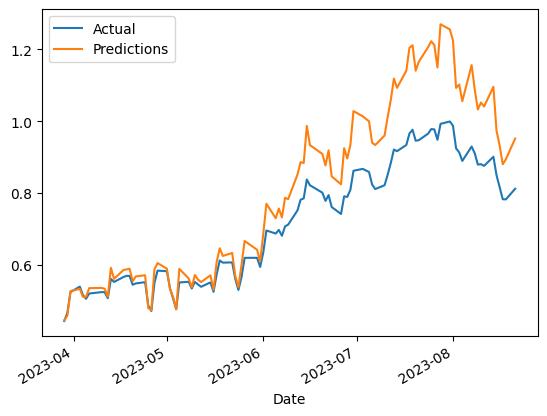

In [58]:
# plotting the predictions with comparison with the actual data
sp500_scaled_test= sp500_scaled[-100:]
sp500_scaled_test['Preds'] = y_pred_scaled

sp500_scaled_test['Close'].plot(kind = 'line')
sp500_scaled_test['Preds'].plot(kind = 'line')
plt.legend(['Actual', 'Predictions'])
plt.show()

# Scaling the result back to normal.

In [59]:
# scaling the value back
sp500_rescaled = sp500_scaled_test[['Close', 'Preds']]
sp500_rescaled.head()
sp500_rescaled

,Close,Preds
Date,,
2023-03-29 00:00:00-04:00,0.445466,0.447594
2023-03-30 00:00:00-04:00,0.468214,0.460529
2023-03-31 00:00:00-04:00,0.526005,0.528637
2023-04-03 00:00:00-04:00,0.541025,0.534685
2023-04-04 00:00:00-04:00,0.517398,0.512648
...,...,...
2023-08-15 00:00:00-04:00,0.850681,0.974196
2023-08-16 00:00:00-04:00,0.817547,0.933509
2023-08-17 00:00:00-04:00,0.783977,0.881015


In [60]:
# rescaling sp500_rescaled to have normal unscaled value
sp500_rescaled = (sp500_rescaled * rg['Close']) + m['Close']
sp500_rescaled.head()


,Close,Preds
Date,,
2023-03-29 00:00:00-04:00,4027.810059,4029.963841
2023-03-30 00:00:00-04:00,4050.830078,4043.052854
2023-03-31 00:00:00-04:00,4109.310059,4111.973448
2023-04-03 00:00:00-04:00,4124.509766,4118.093830
2023-04-04 00:00:00-04:00,4100.600098,4095.793776


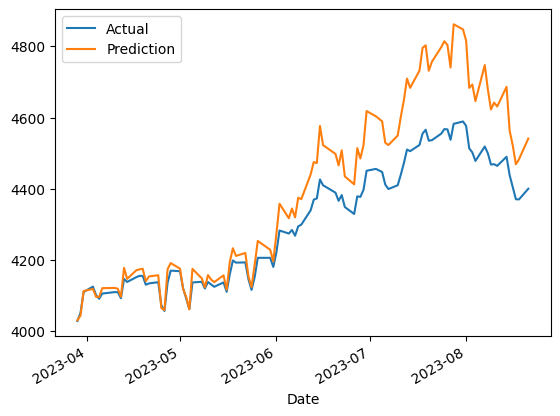

In [61]:
sp500_rescaled.plot(kind = 'line')
plt.legend(['Actual', 'Prediction'])
plt.show()